# Import Packages

In [1]:
import matplotlib.pyplot as plt
from utils import create_dataset,model_plot,history_plot, read_data, plot_data, prepare_train_test_data
import numpy as np
%matplotlib inline
import warnings 
warnings.filterwarnings('ignore')
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM
from sklearn.metrics import mean_absolute_error as mae
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression

In [2]:
clean_df, data = read_data('Totals.csv', debug=True)

         Date  Subscribers
0  2023-04-04            0
1  2023-04-05            0
2  2023-04-06            0
3  2023-04-07            0
4  2023-04-08            0
5  2023-04-09            0
6  2023-04-10            0
7  2023-04-11            0
8  2023-04-12            0
9  2023-04-13            0
----------------------------------------------------
        Date  Subscribers
0 2023-04-04            0
1 2023-04-05            0
2 2023-04-06            0
3 2023-04-07            0
4 2023-04-08            0
5 2023-04-09            0
6 2023-04-10            0
7 2023-04-11            0
8 2023-04-12            0
9 2023-04-13            0


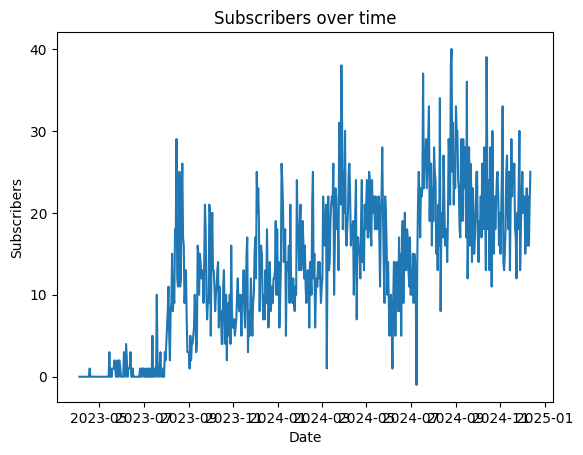

In [3]:
plot_data(clean_df["Subscribers"], title="Subscribers over time", x_label="Date", y_label="Subscribers")

In [4]:
def prepare_train_test_data(data, time_step_in, time_step_out, test_size=0.2):
    X, Y = create_dataset(data, time_step_in, time_step_out)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size)

    # Separate scalers for X and Y
    scaler_X = MinMaxScaler(feature_range=(0,1))
    scaler_Y = MinMaxScaler(feature_range=(0,1))
    x_train = scaler_X.fit_transform(X_train)
    y_train = scaler_Y.fit_transform(Y_train)
    x_test = scaler_X.transform(X_test)
    y_test = scaler_Y.transform(Y_test)

    print(f'x_train shape: {x_train.shape}, y_train shape: {y_train.shape}, x_test shape: {x_test.shape}, y_test shape: {y_test.shape}')
    
    return x_train, x_test, y_train, y_test, scaler_X, scaler_Y
x_train, x_test, y_train, y_test, scaler_X, scaler_Y = prepare_train_test_data(data, time_step_in=30, time_step_out=7, test_size=0.2)

x_train shape: (465, 30), y_train shape: (465, 7), x_test shape: (117, 30), y_test shape: (117, 7)


In [5]:
x_train=x_train.reshape(x_train.shape[0],x_train.shape[1],1)
x_test=x_test.reshape(x_test.shape[0],x_test.shape[1],1)
print(f"X_test shape => {x_test.shape}\nX_train shape => {x_train.shape}")

X_test shape => (117, 30, 1)
X_train shape => (465, 30, 1)


## model definition

In [6]:
lstm_model=Sequential()
lstm_model.add(LSTM(50,return_sequences=True,input_shape=(30,1)))
lstm_model.add(LSTM(50,return_sequences=True))
lstm_model.add(LSTM(50))
lstm_model.add(Dense(7))
lstm_model.compile(loss='mean_absolute_error', optimizer=Adam(learning_rate=0.03), metrics=['mean_absolute_error'])
lstm_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 30, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 7)              │           357 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,157 (199.83 KB)

 Trainable params: 51,157 (199.83 KB)

 Non-trainable params: 0 (0.00 B)

# Cross Validation

In [8]:
tscv = TimeSeriesSplit(n_splits=5)
loss_total = []

for i, (train_index, test_index) in enumerate(tscv.split(x_train), 1):
    X_tr, X_val = x_train[train_index], x_train[test_index]
    y_tr, y_val = y_train[train_index], y_train[test_index]
    
    history = lstm_model.fit(
        X_tr, y_tr,  
        epochs=100, 
        validation_data=(X_val, y_val),  
        verbose=0  
    )
    
    y_pred = lstm_model.predict(X_val)
    loss = mean_absolute_error(y_val, y_pred)
    loss_total.append(loss)
    
  
    print(f"Fold {i}:")
    print(f"  Training data size: {X_tr.shape}")
    print(f"  Validation data size: {X_val.shape}")
    print(f"  MAE: {loss:.4f}")
    print("-" * 30)


mean_loss = np.mean(loss_total)
print(f'\nMean Loss (MAE) over all folds: {mean_loss:.4f}')

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step
Fold 1:
  Training data size: (80, 30, 1)
  Validation data size: (77, 30, 1)
  MAE: 0.1086
------------------------------
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Fold 2:
  Training data size: (157, 30, 1)
  Validation data size: (77, 30, 1)
  MAE: 0.1162
------------------------------
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Fold 3:
  Training data size: (234, 30, 1)
  Validation data size: (77, 30, 1)
  MAE: 0.1067
------------------------------
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Fold 4:
  Training data size: (311, 30, 1)
  Validation data size: (77, 30, 1)
  MAE: 0.0813
------------------------------
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Fold 5:
  Training data size: (388, 30, 1)
  Validation data size: (77, 30, 1)
  MAE: 0.0669
------------------------------

Mean Loss (MAE) over all folds: 0.0959


In [10]:
all_predictions = []
input_window = x_test[-1]  

for i in range(1, 6): 
    print(f'Step {i} ==> Input Window: {input_window}')
    
    if len(input_window.shape) == 1:
        input_window = input_window.reshape(-1, 1)
    
    # Reshape input window to 3D for LSTM (1 sample, time_steps, features)
    y_temp = lstm_model.predict(input_window.reshape(1, input_window.shape[0], input_window.shape[1]))
    print(f"Prediction Output (y_temp): {y_temp}")
    all_predictions.extend(y_temp[0]) 
    input_window = np.roll(input_window, -1, axis=0)
    input_window[-1] = y_temp[0][0]  

Step 1 ==> Input Window: [[0.3902439 ]
 [0.55      ]
 [0.34146341]
 [0.36585366]
 [0.48780488]
 [0.55      ]
 [0.56097561]
 [0.525     ]
 [0.65853659]
 [0.26829268]
 [0.4       ]
 [0.58536585]
 [0.56097561]
 [0.45      ]
 [0.51219512]
 [0.34146341]
 [0.7804878 ]
 [0.6097561 ]
 [0.53658537]
 [0.95      ]
 [0.775     ]
 [0.45      ]
 [0.625     ]
 [0.525     ]
 [0.75609756]
 [0.46153846]
 [0.43589744]
 [0.46341463]
 [0.51219512]
 [0.63414634]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction Output (y_temp): [[0.5803963  0.6214942  0.46448645 0.43772095 0.40424573 0.487087
  0.4386633 ]]
Step 2 ==> Input Window: [[0.55      ]
 [0.34146341]
 [0.36585366]
 [0.48780488]
 [0.55      ]
 [0.56097561]
 [0.525     ]
 [0.65853659]
 [0.26829268]
 [0.4       ]
 [0.58536585]
 [0.56097561]
 [0.45      ]
 [0.51219512]
 [0.34146341]
 [0.7804878 ]
 [0.6097561 ]
 [0.53658537]
 [0.95      ]
 [0.775     ]
 [0.45      ]
 [0.625     ]
 [0.525     ]
 [0.75609756]
 [0.46153846]
 [0.43589744]
 [0.46341463]
 [0.

In [11]:
all_predictions=np.array(all_predictions)
all_predictions

array([0.5803963 , 0.6214942 , 0.46448645, 0.43772095, 0.40424573,
       0.487087  , 0.4386633 , 0.500323  , 0.46686274, 0.4798408 ,
       0.42822737, 0.36340114, 0.43864113, 0.49165335, 0.42555678,
       0.45161897, 0.44790563, 0.53431433, 0.27339157, 0.45782244,
       0.48596323, 0.43242827, 0.4721722 , 0.47081923, 0.2962075 ,
       0.42638987, 0.47774774, 0.6201683 , 0.4900803 , 0.4632682 ,
       0.24788517, 0.5348134 , 0.4228868 , 0.57223165, 0.5880282 ],
      dtype=float32)

In [12]:
num_samples = len(all_predictions) // 7
all_predictions_reshaped = all_predictions.reshape(num_samples, 7)
y_next_30 = scaler_Y.inverse_transform(all_predictions_reshaped)
y_next_30=np.round(y_next_30)
print(y_next_30)

[[23. 24. 18. 17. 16. 19. 17.]
 [20. 18. 19. 17. 14. 17. 19.]
 [17. 18. 17. 21. 10. 18. 18.]
 [17. 18. 18. 11. 16. 19. 24.]
 [20. 18.  9. 21. 16. 22. 23.]]


In [13]:
x_train= x_train.reshape(x_train.shape[0], -1)
x_test= x_test.reshape(x_test.shape[0], -1)

print(f"X_test shape => {x_test.shape}\nX_train shape => {x_train.shape}")

X_test shape => (117, 30)
X_train shape => (465, 30)


In [14]:
x_test=scaler_X.inverse_transform(x_test)
x_train=scaler_X.inverse_transform(x_train)

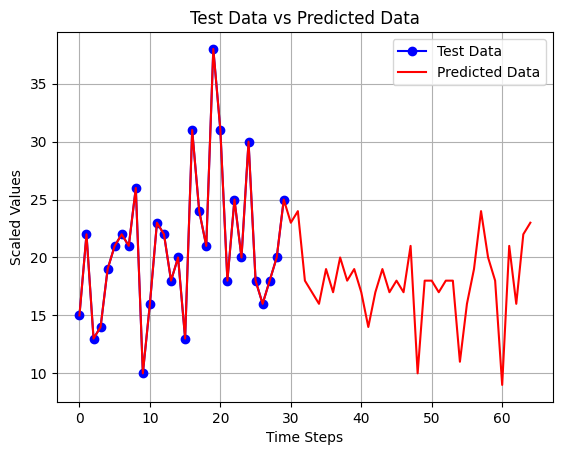

In [15]:
plt.plot(x_test[-1], label='Test Data', color='blue', marker='o')
plt.plot(np.hstack([x_test[-1], y_next_30.reshape(-1)]), label='Predicted Data', color='red')
plt.title('Test Data vs Predicted Data')
plt.xlabel('Time Steps')
plt.ylabel('Scaled Values')
plt.legend()
plt.grid(True)
plt.show()

In [16]:
last_date = clean_df.index[-1]
total_sub = np.sum(np.array(clean_df['Subscribers']))
total_next_30 = np.sum(y_next_30)
print(f"Total subscribers till {last_date}: {total_sub}, next_30_days: {np.round(total_next_30)} => final after 30 days: {total_sub + round(total_next_30)}")

Total subscribers till 2024-12-12 00:00:00: 8117, next_30_days: 629.0 => final after 30 days: 8746
